# Linear Regression

In [ ]:
import numpy as np
import pandas as pd
import os
import random
import time
import matplotlib.pyplot as plt
from collections import Counter


from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, precision_recall_curve, auc, average_precision_score, accuracy_score

import tensorflow as tf

In [ ]:
#import data
df = pd.read_csv("/Users/advait/Downloads/encodings (1).csv")

#split data into train/test
X = df

df_outcomes = pd.read_csv("/Users/advait/Downloads/small_filtered_geotagged_surgery_campaigns.csv")
y_new = df_outcomes['raised_amnt'].to_numpy() / df_outcomes['goal_amnt'].to_numpy()

y = []
for item in y_new:
    if item >= 1:
        y.append(1)
    else:
        y.append(0)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=5)


In [ ]:
param_grid = {
        'C': [0.01, 0.1, 1, 10, 100, 1000]
        }

log = LogisticRegression(penalty='l1', solver='liblinear')
cv = StratifiedKFold(5, shuffle=True, random_state=5)
model = GridSearchCV(log, param_grid, cv = cv, refit = True, verbose=True, n_jobs = -1, scoring = 'average_precision')

%time model.fit(x_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.5s finished


CPU times: user 709 ms, sys: 154 ms, total: 863 ms
Wall time: 5.93 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l1',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='average_precision', verbose=True)

In [ ]:
best_params = model.best_estimator_.get_params()
best_params

{'C': 10,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [ ]:
#assess performance

y_pred = model.predict_proba(x_test)
# Convert proabilities to binary output for performance assessment, 0.5 cutoff
y_pred_binary = np.where(y_pred[:,1] > 0.5, 1, 0)

# Metrics at different probability cutoffs
# (pos label assigned if pos class probability > cutoff)

cutoffs = np.arange(0.1, 1, 0.1)
target_names = ['negative', 'positive']

for cutoff in cutoffs:
  print('Cutoff: ', round(cutoff, 2))
  print(classification_report(y_test, np.where(y_pred[:,1] > cutoff, 1, 0), target_names=target_names))


Cutoff:  0.1
              precision    recall  f1-score   support

    negative       0.86      0.62      0.72       172
    positive       0.13      0.36      0.19        28

    accuracy                           0.58       200
   macro avg       0.49      0.49      0.46       200
weighted avg       0.75      0.58      0.65       200

Cutoff:  0.2
              precision    recall  f1-score   support

    negative       0.86      0.80      0.83       172
    positive       0.12      0.18      0.15        28

    accuracy                           0.71       200
   macro avg       0.49      0.49      0.49       200
weighted avg       0.75      0.71      0.73       200

Cutoff:  0.3
              precision    recall  f1-score   support

    negative       0.86      0.85      0.85       172
    positive       0.13      0.14      0.14        28

    accuracy                           0.75       200
   macro avg       0.50      0.50      0.50       200
weighted avg       0.76      0.75  

In [ ]:
# Metrics at Positive class Recall of at least 90

from sklearn.metrics import f1_score
# get roc
y_pos = y_pred[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pos)

# get index of sensitivity closest to 90+
indeces = np.where(tpr >= 0.9)[0]
i = indeces[tpr[indeces].argmin()]

# calculate metrics
auroc = auc(fpr, tpr)
sens = tpr[i]*100
spec = (1 - fpr[i])*100
cutoff = thresholds[i]
y_pred_bin = (y_pred[:,1] >= cutoff).astype(int)
acc = accuracy_score(y_test, y_pred_bin)*100
avg_prec = average_precision_score(y_test, y_pos)*100
f1 = f1_score(y_test, y_pred_bin)*100

print("Recall:\t\t\t", round(sens, 3))
print("Specificity:\t\t", round(spec,3))
print("AUROC:\t\t\t", round(auroc, 3))
print("Probabitiy cutoff:\t", round(cutoff, 3))
print('Accuracy:\t\t', round(acc, 3))
print('Average Precision:\t', round(avg_prec, 3))
print('F1-score:\t\t', round(f1, 3))

Recall:			 92.857
Specificity:		 9.884
AUROC:			 0.462
Probabitiy cutoff:	 0.002
Accuracy:		 21.5
Average Precision:	 14.659
F1-score:		 24.88


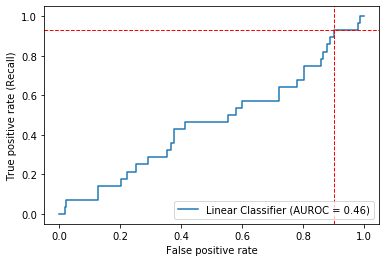

In [ ]:
# plot ROC curve
plt.plot(fpr, tpr, label='Linear Classifier (AUROC = %0.2f)' % (auroc))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.axhline(y=sens/100, color='r', linestyle='--', linewidth=1)
plt.axvline(x=1-spec/100, color='r', linestyle='--', linewidth=1)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate (Recall)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#get coefficients and feature names
param_list = model.best_estimator_.coef_
param_list_new = []
for item in param_list:
    for element in item:
        param_list_new.append(element)

cols = list(X.columns)

#get total initial features and non-zero featuers after CV
print(len(param_list[0]))
np.count_nonzero(param_list)

1024


225

## T-SNE and PCA Plot Generation

In [ ]:
from sklearn.manifold import TSNE
from keras.datasets import mnist
from sklearn.datasets import load_iris
from numpy import reshape
import seaborn as sns
import pandas as pd
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("/Users/advait/Downloads/encodings (1).csv")
df

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,-0.138775,-0.134521,-0.063372,-0.154899,0.087668,0.105536,-0.074884,0.269079,-0.011446,0.147174,...,0.085047,0.044644,0.029305,-0.055580,0.076145,0.184646,0.103795,-0.086645,0.180766,-0.033928
1,0.003642,-0.043849,0.000433,-0.031345,0.003612,0.077938,0.005614,0.115526,-0.080045,-0.048168,...,-0.066312,0.019515,0.013033,0.034492,0.065479,0.017960,0.114549,-0.009609,0.083476,0.033553
2,-0.038522,-0.059176,-0.189841,0.051283,0.212852,0.208619,-0.172545,0.164035,-0.020979,0.108466,...,-0.134324,0.122922,-0.254643,-0.016278,0.119167,0.000146,0.209319,-0.016491,0.454021,0.037648
3,-0.067542,-0.002222,-0.109844,-0.031730,0.078422,0.124127,-0.148275,0.207102,-0.072784,0.059620,...,-0.086426,0.095198,-0.206683,-0.032535,0.164407,0.199990,0.233593,-0.102626,0.227396,0.096586
4,-0.021845,-0.075340,0.009053,0.020771,0.067336,0.059046,0.019739,0.091832,-0.079951,-0.037688,...,-0.062683,0.016980,-0.026042,0.068283,0.063758,0.005649,0.087495,0.032726,0.176272,-0.023746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.038021,-0.047989,-0.040039,-0.032782,0.060194,0.140140,-0.044515,0.115942,-0.080381,-0.001695,...,-0.091513,-0.015340,-0.089240,0.018703,0.097285,0.044413,0.130693,-0.012833,0.210558,-0.002691
996,-0.194847,-0.097017,-0.176285,-0.074455,0.048515,0.169162,-0.271787,0.235547,-0.189705,0.049325,...,-0.056099,0.110536,-0.183148,0.037221,0.178865,0.089573,0.154234,-0.258560,0.422816,0.019143
997,-0.041421,-0.009365,-0.043257,-0.029077,0.005345,0.034554,0.016982,0.103925,0.034755,-0.068198,...,0.006713,0.027529,-0.007504,0.030613,0.112227,0.103403,0.080604,-0.021152,0.100993,-0.014497
998,-0.078937,-0.010870,-0.183584,0.067633,0.160960,0.044840,-0.133202,0.238594,0.041021,-0.015746,...,-0.088993,0.030635,-0.147651,-0.059050,0.205662,0.046806,0.210122,-0.005182,0.265557,0.047361


In [ ]:
#bin crowdfunding campaign successes

df_outcomes = pd.read_csv("/Users/advait/Downloads/small_filtered_geotagged_surgery_campaigns.csv")
df_outcomes['percent_raised'] = df_outcomes['raised_amnt'].to_numpy() / df_outcomes['goal_amnt'].to_numpy()

y = pd.qcut(df_outcomes['percent_raised'], 4, labels=False)
y = y+1
y

0      4
1      3
2      1
3      2
4      2
      ..
995    1
996    4
997    4
998    1
999    3
Name: percent_raised, Length: 1000, dtype: int64

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.788151
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.526741
[t-SNE] KL divergence after 1000 iterations: 0.378406


[Text(0.5, 1.0, 'Crowdfunding data T-SNE projection')]

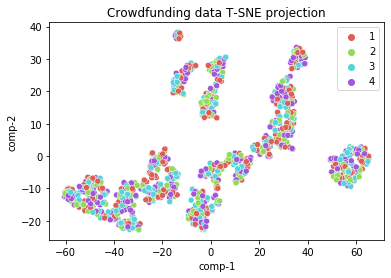

In [ ]:
tsne = TSNE(n_components=2, verbose=1)
x = df.to_numpy()
z = tsne.fit_transform(x) 


df = pd.DataFrame()
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
df['y'] = y

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 4),
                data=df).set(title="Crowdfunding data T-SNE projection") 

Text(0.5, 1.0, 'PCA of Crowdfunding Campaigns')

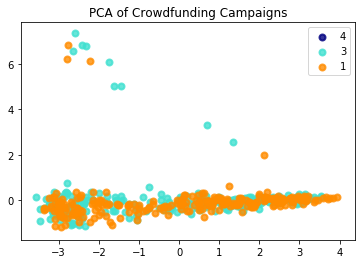

In [ ]:
pca = PCA(n_components=2)
X_r = pca.fit(x).transform(x)

plt.figure()
colors = ["navy", "turquoise", "darkorange"]
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], y):
    plt.scatter(
        X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of Crowdfunding Campaigns")